<img align="left" src = https://linea.org.br/wp-content/themes/LIneA/imagens/logo-header.jpg width=100 style="padding: 20px"> 

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=160 style="padding: 20px">  

# Executing Rail with DP0.1 sample - FALTA ESCREVER NELE, mas a execução foi

**Contact author**: Heloisa da Silva Mengisztki ([heloisasmengisztki@gmail.com](mailto:heloisasmengisztki@gmail.com)) 

**Last verified run**: 2022-12-01 (YYYY-MM-DD) <br><br>

Here we are going to execute rail using a dp0.1 sample, the reason is that the dp0.1 sample has the redshift column so we can train and test the algorithm and see what we can obtain.

## Imports

In [1]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rail
import qp
import tables_io

from rail.core.utils import RAILDIR
from rail.core.data import TableHandle, DataStore
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.bpz_lite import Inform_BPZ_lite, BPZ_lite

from rail.evaluation.evaluator import Evaluator

%matplotlib inline 
help(rail)

Help on package rail:

NAME
    rail

PACKAGE CONTENTS
    core (package)

SUBMODULES
    estimation
    evaluation

FILE
    (built-in)




## General Configs

In [2]:
pd.set_option('display.max_rows', 20)

In [3]:
CURR_DIR = os.getcwd()
CURR_DIR, RAILDIR

('/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals',
 '/home/heloisamengisztki/.local/lib/python3.10/site-packages')

In [4]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Reading DP0.1 csv

In [5]:
interesting_headers = [
"coadd_objects_id",
"ra",
"dec",
"mag_g",
"magerr_g",
"mag_i",
"magerr_i",
"mag_r",
"magerr_r",
"mag_u",
"magerr_u",
"mag_y",
"magerr_y",
"mag_z",
"magerr_z",
"z_true"
]

trainFile = os.path.join(CURR_DIR, '../../../../DATA/dp0_train_random.csv')
full_data = pd.read_csv(trainFile, usecols=interesting_headers)

In [7]:
size = len(full_data)//2

train = full_data.sample(n=size,random_state=1, ignore_index=True)
test = full_data.drop(train.index)

In [8]:
train

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
0,20398552035403659,1.823953,54.6984,-31.0869,26.8251,26.6155,26.8103,26.0273,NaN,29.0353,0.6011,0.1527,0.1929,0.1832,-2.3901,17.3861
1,21339738283734711,1.263857,58.8306,-29.5195,24.8793,24.9321,24.5301,23.5242,23.0743,22.5046,0.1729,0.0576,0.0477,0.0351,0.0607,0.0636
2,16875995952883236,0.804843,72.6680,-36.8178,NaN,27.5055,26.4091,25.0502,24.6516,24.7865,-1.2992,0.6156,0.2412,0.1346,0.2553,0.5243
3,16844810195348286,1.742914,60.6724,-36.1140,25.3483,25.3531,24.9345,24.5894,23.9109,23.9911,0.2413,0.0876,0.0651,0.0750,0.1154,0.2577
4,18577640520718568,2.054134,51.3530,-33.2838,NaN,27.1202,25.3000,25.8467,28.3170,NaN,-25.3218,0.7643,0.2560,0.7296,21.2065,-1.9019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40401,16866920686982890,1.113916,69.3063,-37.0266,26.6502,26.6606,26.4950,26.5027,25.9347,25.9468,0.4940,0.1722,0.1720,0.2979,0.4391,1.1006
40402,12785963021380695,1.135619,70.2077,-43.6824,27.3600,26.4632,26.3504,26.6731,25.7673,NaN,0.8608,0.1339,0.1361,0.3477,0.3365,-2.7382
40403,22289596071047364,2.641011,61.6062,-27.1075,27.9764,27.0468,28.3835,NaN,25.0240,23.9222,3.6744,0.4986,1.8265,-3.0669,0.3637,0.2643
40404,17741719625820553,2.272436,72.5219,-35.6951,25.1357,24.5185,24.6593,24.6438,26.4109,23.7843,0.2719,0.0628,0.0751,0.1447,1.3499,0.3396


In [9]:
test

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
40406,14320460346985530,1.083167,50.4691,-41.1147,26.5377,26.7127,26.0790,26.0657,25.5970,25.3729,0.5290,0.2024,0.1510,0.2448,0.4600,0.6812
40407,19505632629520281,1.228961,62.7543,-31.6018,26.9483,26.6153,26.6607,25.9465,24.8356,24.4789,0.5684,0.1813,0.1866,0.1587,0.1882,0.2849
40408,14355786452989168,1.005510,65.7566,-40.9686,25.4074,26.4859,25.8216,25.7213,25.3755,24.4304,0.2320,0.1810,0.1192,0.2347,0.4900,0.3558
40409,13568411573424664,1.727726,71.6283,-41.7451,26.5434,25.7170,25.7152,25.4834,25.6776,25.0296,0.3836,0.0772,0.0948,0.1318,0.4083,0.4969
40410,16840279004839546,0.995374,59.1503,-36.0538,27.0809,26.0884,25.5183,25.5132,24.7519,24.8049,0.9508,0.1255,0.0814,0.1516,0.2752,0.4863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80807,18608160558314795,1.541024,64.3444,-32.8562,24.7260,25.0259,24.9061,24.6635,24.5158,23.5274,0.1042,0.0496,0.0501,0.0727,0.1781,0.1704
80808,16862801813338393,0.346085,67.1182,-36.9476,25.2311,23.7843,22.1979,21.5966,21.2622,21.2403,0.2429,0.0249,0.0083,0.0075,0.0150,0.0271
80809,15178221150575213,2.434222,68.4211,-39.3488,26.0099,25.9614,25.9529,26.3746,27.7745,25.2191,0.3812,0.1130,0.1440,0.4056,3.7003,0.7573
80810,18599888451286803,0.867375,59.8577,-34.0727,26.6045,26.7943,27.5758,26.7163,27.5833,NaN,0.4216,0.1725,0.4238,0.3406,2.4577,-1.1485


---

In [10]:
columns_remmap = {
"coadd_objects_id": "id",
"ra": "coord_ra",
"dec": "coord_dec",
"mag_g": "mag_g_lsst",
"magerr_g": "mag_err_g_lsst",
"mag_i": "mag_i_lsst",
"magerr_i": "mag_err_i_lsst",
"mag_r": "mag_r_lsst",
"magerr_r": "mag_err_r_lsst",
"mag_u": "mag_u_lsst",
"magerr_u": "mag_err_u_lsst",
"mag_y": "mag_y_lsst",
"magerr_y": "mag_err_y_lsst",
"mag_z": "mag_z_lsst",
"magerr_z": "mag_err_z_lsst",
"z_true": "redshift"
}


col_remapper_train = ColumnMapper.make_stage(name='col_remapper_train', columns=columns_remmap)
table_conv_train = TableConverter.make_stage(name='table_conv_train', output_format='numpyDict')

results_remmaped = col_remapper_train(train)
train_data = table_conv_train(results_remmaped)

Inserting handle into data store.  input: None, col_remapper_train
Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


In [11]:
type(train_data.data)

collections.OrderedDict

In [12]:
type(results_remmaped.data)

pandas.core.frame.DataFrame

In [13]:
type(train_data.data)

collections.OrderedDict

In [14]:
full_sample = tables_io.convertObj(train_data.data, tables_io.types.PD_DATAFRAME)
type(full_sample)

pandas.core.frame.DataFrame

## PRIORS - Inform

In [21]:
columns_file = os.path.join(CURR_DIR, '../configs/bpz.columns')
inform_bpz = Inform_BPZ_lite.make_stage(
    name='inform_bpzlite', 
    input="output_table_conv_train", #"inprogress_output_table_conv_train.hdf5", 
    model='trained_BPZ_output.pkl', ##não precisaria isso pro bpz
    hdf5_groupname='', 
    columns_file=columns_file
)
inform_bpz.config.to_dict()

{'output_mode': 'default',
 'hdf5_groupname': '',
 'save_train': True,
 'zmin': 0.0,
 'zmax': 3.0,
 'nzbins': 301,
 'band_names': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'band_err_names': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'nondetect_val': 99.0,
 'data_path': 'None',
 'columns_file': '/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals/../configs/bpz.columns',
 'spectra_file': 'SED/CWWSB4.list',
 'm0': 20.0,
 'nt_array': [1, 2, 3],
 'mmin': 18.0,
 'mmax': 29.0,
 'init_kt': 0.3,
 'init_zo': 0.4,
 'init_alpha': 1.8,
 'init_km': 0.1,
 'prior_band': 'mag_i_lsst',
 'redshift_col': 'redshift',
 'type_file': '',
 'name': 'inform_bpzlite',
 'input': 'output_table_conv_train',
 'model': 'trained_BPZ_output.pkl',
 'config': None,
 'aliases': {'model': 'model_inform_bpzlite'}}

In [22]:
%%time
returned = inform_bpz.inform(train_data)

using 39201 galaxies in calculation
best values for fo and kt:
[1.]
[0.3]
minimizing for type 0
[0.4 1.8 0.1] 32657.1133352044
[0.42 1.8  0.1 ] 32369.992706456105
[0.4  1.89 0.1 ] 33641.75523571088
[0.4   1.8   0.105] 32227.611093612963
[0.41333333 1.71       0.10333333] 31842.371020315353
[0.42  1.62  0.105] 31900.1164882998
[0.42222222 1.74       0.10555556] 31856.438581263978
[0.4037037  1.7        0.10925926] 31769.575553771014
[0.39555556 1.65       0.11388889] 31885.37250738644
[0.42617284 1.63333333 0.10709877] 31975.33592349207
[0.41962963 1.675      0.10657407] 31823.32995356452
[0.40222222 1.65       0.10722222] 31774.259451420126
[0.4037037  1.64       0.11203704] 31922.16602578276
[0.41092593 1.6925     0.10550926] 31786.539127307253
[0.39160494 1.68666667 0.10808642] 31744.78001130266
[0.37759259 1.6925     0.10884259] 31754.965221959355
[0.38742798 1.66527778 0.11086934] 31736.607658630073
[0.37567901 1.65166667 0.11354938] 31738.094179234206
[0.38626886 1.71796296 0.1115

___

## Posterior - Estimate


In [23]:
results_remmaped = col_remapper_train(test)
test_data = table_conv_train(results_remmaped)

Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


In [24]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file=columns_file, 
    model=inform_bpz.get_handle('model'))

In [25]:
estimate_bpz.config_options['data_path'].value

'None'

In [26]:
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 40406
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


In [27]:
bpz_estimated().build_tables()

results_tables = tables_io.convertObj(bpz_estimated().build_tables()['ancil'], tables_io.types.PD_DATAFRAME)
results_tables

,zmean,zmode
0,NaN,0.00
1,1.091669,1.10
2,NaN,0.00
3,1.023960,0.78
4,NaN,0.00
...,...,...
40401,1.663662,1.65
40402,NaN,0.00
40403,NaN,0.00
40404,2.229410,2.82


## Evaluate

In [21]:
test_data_orig = test_data.data

evaluator = Evaluator.make_stage(name=f'bpz_eval', truth=test_data_orig)
result_dict = evaluator.evaluate(bpz_estimated, test_data_orig)

Inserting handle into data store.  truth: OrderedDict([('id', array([20398552035403659, 21339738283734711, 16875995952883236, ...,
       22289596071047364, 17741719625820553, 18608272227467670])), ('redshift', array([1.823953 , 1.2638574, 0.804843 , ..., 2.6410112, 2.2724364,
       0.7283023])), ('coord_ra', array([54.6984, 58.8306, 72.668 , ..., 61.6062, 72.5219, 64.0179])), ('coord_dec', array([-31.0869, -29.5195, -36.8178, ..., -27.1075, -35.6951, -34.1576])), ('mag_u_lsst', array([26.8251, 24.8793,     nan, ..., 27.9764, 25.1357, 26.9934])), ('mag_g_lsst', array([26.6155, 24.9321, 27.5055, ..., 27.0468, 24.5185, 26.9048])), ('mag_r_lsst', array([26.8103, 24.5301, 26.4091, ..., 28.3835, 24.6593, 26.0745])), ('mag_i_lsst', array([26.0273, 23.5242, 25.0502, ...,     nan, 24.6438, 25.5443])), ('mag_z_lsst', array([    nan, 23.0743, 24.6516, ..., 25.024 , 26.4109, 28.7894])), ('mag_y_lsst', array([29.0353, 22.5046, 24.7865, ..., 23.9222, 23.7843,     nan])), ('mag_err_u_lsst', array([

/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:176: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval: inprogress_output_bpz_eval.hdf5, bpz_eval
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'


In [22]:
results_tables = tables_io.convertObj(result_dict.data, tables_io.types.PD_DATAFRAME)
results_tables.head()

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,NaN,NaN,NaN,1.0,NaN,0.355267,-0.129102,0.01183,0.289013,NaN,NaN


___
## Resultado pz x spec-z

In [23]:
zmode = bpz_estimated().ancil['zmode']

Text(0, 0.5, 'bpz photo-z')

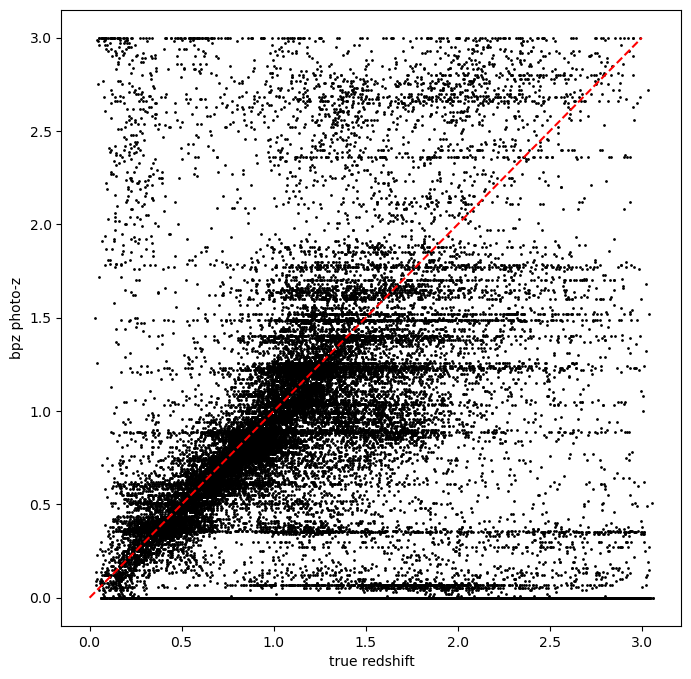

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['redshift'],zmode,s=1,c='k',label='simple bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

CONCLUSÃO

1. Cortou alguns pits. Por que?
2. Os pontos estão relativamente mais próximos da linha mas ainda tem bastante pontos espalhados. Por que?